In [14]:
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os

# Helper function to get rows in data frame associated 
# with each file
def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)


current_path = os.getcwd()
subset_path = current_path + "\\subset0\\"
file_list = glob(subset_path+"*.mhd")

df_node = pd.read_csv("annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename)
df_node = df_node.dropna()

# Looping over the image files
fcount = 0
for img_file in file_list:
    print("Getting mask for image file %s" % img_file.replace(subset_path,""))
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if len(mini_df)>0:       # some files may not have a nodule--skipping those 
        biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]   # just using the biggest node
        node_x = mini_df["coordX"].values[biggest_node]
        node_y = mini_df["coordY"].values[biggest_node]
        node_z = mini_df["coordZ"].values[biggest_node]
        diam = mini_df["diameter_mm"].values[biggest_node]

# There are 89 files in the subsection
print(len(file_list))
# there are 112 instances
print(len(df_node))
print(len(mini_df))


Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd
Getting mask for image file 1.

In [44]:
from __future__ import print_function, division
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
#Some helper functions

def make_mask(center,diam,z,width,height,spacing,origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))

############
#
# Getting list of image files
luna_path = os.getcwd()
luna_subset_path = luna_path+"\\subset0\\"
output_path = luna_path+"\\output\\"
file_list=glob(luna_subset_path+"*.mhd")
print(file_list)

#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)# The locations of the nodes

['C:\\Users\\azkei\\Desktop\\lung_cancer_data2\\subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd', 'C:\\Users\\azkei\\Desktop\\lung_cancer_data2\\subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd', 'C:\\Users\\azkei\\Desktop\\lung_cancer_data2\\subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd', 'C:\\Users\\azkei\\Desktop\\lung_cancer_data2\\subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd', 'C:\\Users\\azkei\\Desktop\\lung_cancer_data2\\subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd', 'C:\\Users\\azkei\\Desktop\\lung_cancer_data2\\subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd', 'C:\\Users\\azkei\\Desktop\\lung_cancer_data2\\subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd', 'C:\\Users\\azkei\\Desktop\\lung_cancer_data2\\subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.12626457893177825889

In [47]:
df_node = pd.read_csv("annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()

print(df_node)
#####
#
# Looping over the image files
#
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        # load the data once
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            # just keep 3 slices
            imgs = np.ndarray([3,height,width],dtype=np.float32)
            masks = np.ndarray([3,height,width],dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                             int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
            np.save(os.path.join(output_path,"images_%04d_%04d.npy" % (fcount, node_idx)),imgs)
            np.save(os.path.join(output_path,"masks_%04d_%04d.npy" % (fcount, node_idx)),masks)

                                              seriesuid      coordX  \
23    1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896... -100.567944   
25    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   46.188539   
26    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   36.392044   
28    1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  136.434059   
86    1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...  145.967465   
98    1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931...   59.114146   
103   1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651...   33.832826   
110   1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637...  -96.469304   
117   1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890...   88.231452   
129   1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583...  -84.046581   
130   1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583...  -70.323099   
131   1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583...  -86.853843   
132   1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583...   99.634489   
135   

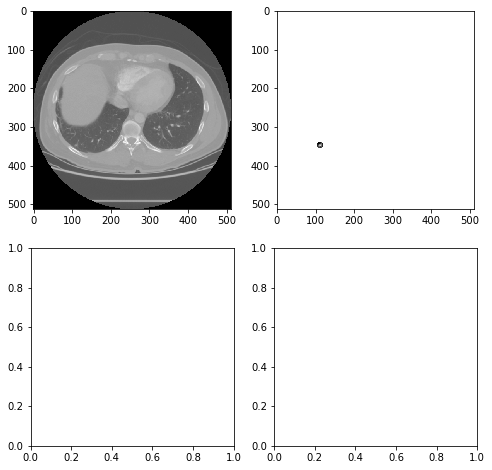

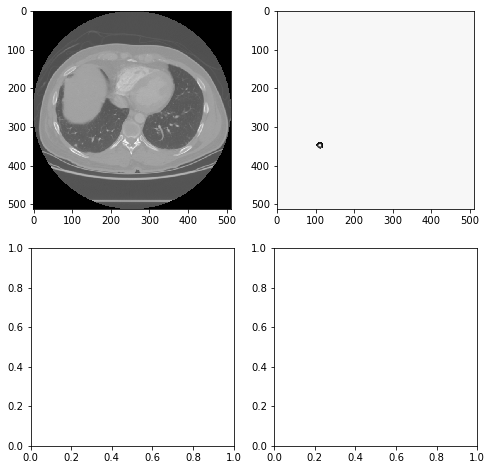

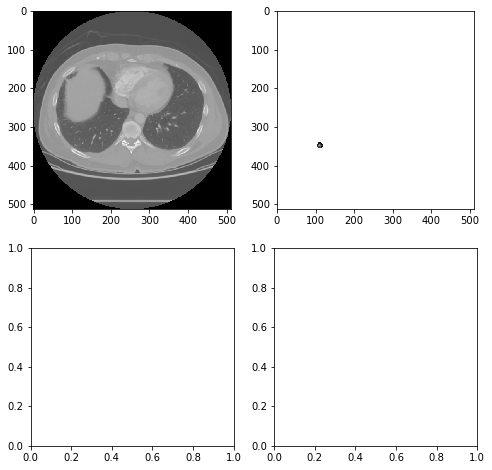

In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np

output_path = os.getcwd() + "\\output\\"
imgs = np.load(output_path+'images_0001_0023.npy')
masks = np.load(output_path+'masks_0001_0023.npy')

for i in range(len(imgs)):
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show()

(512, 512)
(512, 512)
image 0


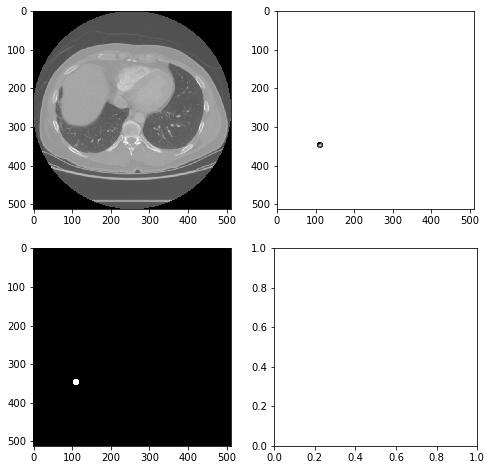

(512, 512)
(512, 512)
image 1


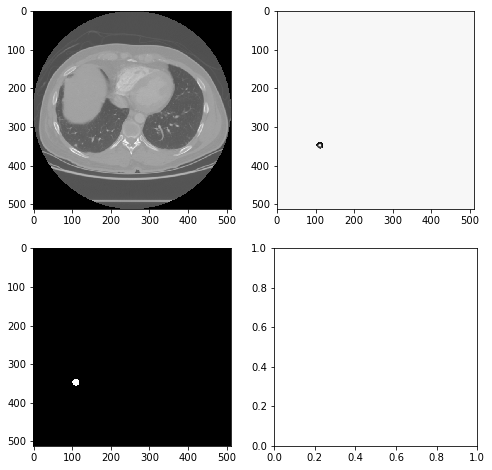

(512, 512)
(512, 512)
image 2


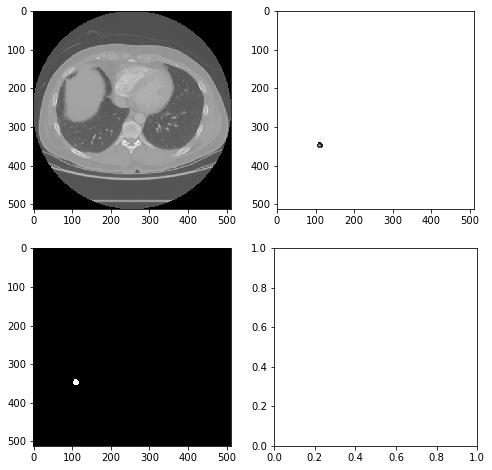

In [3]:
import matplotlib.pyplot as plt
import os
import numpy as np

output_path = os.getcwd() + "\\output\\"
imgs = np.load(output_path+'images_0001_0023.npy')
masks = np.load(output_path+'masks_0001_0023.npy')

for i in range(len(imgs)):
    print(imgs[i].shape)
    print(masks[i].shape)
    print("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[1,0].imshow(masks[i],cmap='gray')
    ax[0,1].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show()

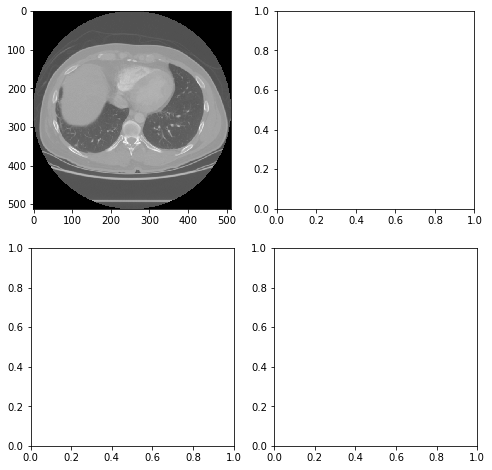

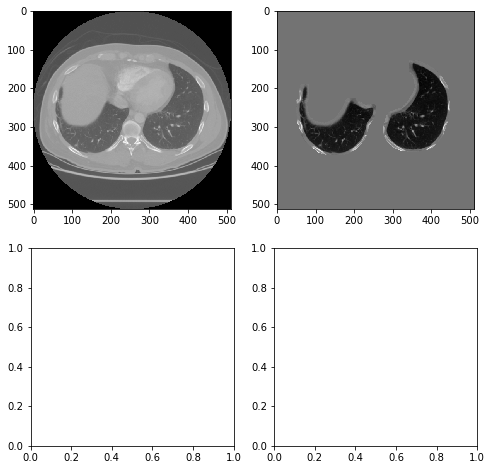

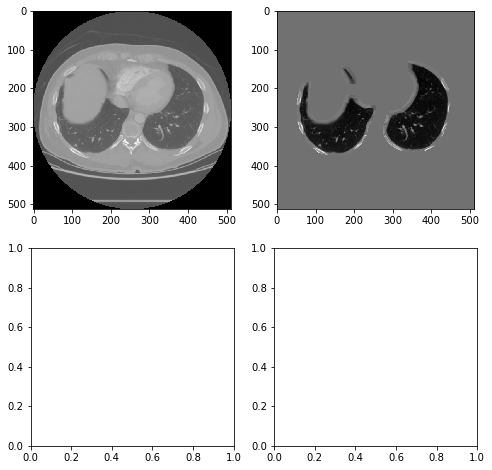

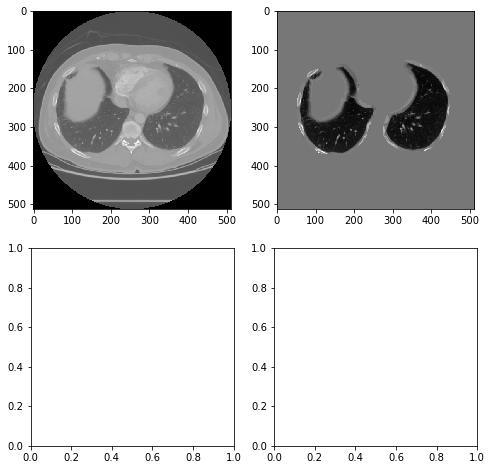

In [8]:
import matplotlib.pyplot as plt
import os
import numpy as np

output_path = os.getcwd() + "\\output\\"

imgs = np.load(output_path+'images_0001_0023.npy')
lungmasks = np.load(output_path+'lungmask_0001_0023.npy')

for i in range(len(imgs)):
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(imgs[i]*lungmasks[i],cmap='gray')
    plt.show()

In [7]:
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
from glob import glob

working_path = os.getcwd()+"\\output\\"
file_list=glob(working_path+"images_*.npy")

for img_file in file_list:
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64) 
    print ("on image", img_file)
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        #Standardize the pixel values
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std
        # Find the average pixel value near the lungs
        # to renormalize washed out images
        middle = img[100:400,100:400] 
        mean = np.mean(middle)  
        max = np.max(img)
        min = np.min(img)
        # To improve threshold finding, I'm moving the 
        # underflow and overflow on the pixel spectrum
        img[img==max]=mean
        img[img==min]=mean
        #
        # Using Kmeans to separate foreground (radio-opaque tissue)
        # and background (radio transparent tissue ie lungs)
        # Doing this only on the center of the image to avoid 
        # the non-tissue parts of the image as much as possible
        #
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
        #
        # I found an initial erosion helful for removing graininess from some of the regions
        # and then large dialation is used to make the lung region 
        # engulf the vessels and incursions into the lung cavity by 
        # radio opaque tissue
        #
        eroded = morphology.erosion(thresh_img,np.ones([4,4]))
        dilation = morphology.dilation(eroded,np.ones([10,10]))
        #
        #  Label each region and obtain the region properties
        #  The background region is removed by removing regions 
        #  with a bbox that is to large in either dimnsion
        #  Also, the lungs are generally far away from the top 
        #  and bottom of the image, so any regions that are too
        #  close to the top and bottom are removed
        #  This does not produce a perfect segmentation of the lungs
        #  from the image, but it is surprisingly good considering its
        #  simplicity. 
        #
        labels = measure.label(dilation)
        label_vals = np.unique(labels)
        regions = measure.regionprops(labels)
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
                good_labels.append(prop.label)
        mask = np.ndarray([512,512],dtype=np.int8)
        mask[:] = 0
        #
        #  The mask here is the mask for the lungs--not the nodes
        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask 
        #
        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
        imgs_to_process[i] = mask
    np.save(img_file.replace("images","lungmask"),imgs_to_process)
    

#
#    Here we're applying the masks and cropping and resizing the image
#


file_list=glob(working_path+"lungmask_*.npy")
out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks
for fname in file_list:
    print("working on file ", fname)
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        node_mask = node_masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img= mask*img          # apply lung mask
        #
        # renormalizing the masked image (in the mask region)
        #
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
        img = img-new_mean
        img = img/new_std
        #make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        #
        # Finding the global min and max row over all regions
        #
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col-min_col
        height = max_row - min_row
        if width > height:
            max_row=min_row+width
        else:
            max_col = min_col+height
        # 
        # cropping the image down to the bounding box for all regions
        # (there's probably an skimage command that can do this in one line)
        # 
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
            pass
        else:
            # moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img,[512,512])
            new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
            out_images.append(new_img)
            out_nodemasks.append(new_node_mask)

num_images = len(out_images)
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(working_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(working_path+"testMasks.npy",final_masks[rand_i[:test_i]])

on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0001_0023.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0002_0025.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0002_0026.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0003_0028.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0005_0086.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0007_0098.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0008_0103.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0009_0110.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0010_0117.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0011_0129.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0011_0130.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0011_0131.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_

on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0084_1124.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0084_1125.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0085_1137.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0085_1138.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0086_1141.npy
on image C:\Users\azkei\Desktop\lung_cancer_data2\output\images_0088_1180.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0001_0023.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0002_0025.npy


C:\Users\azkei\Anaconda3\envs\python35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0002_0026.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0003_0028.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0005_0086.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0007_0098.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0008_0103.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0009_0110.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0010_0117.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0011_0129.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0011_0130.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0011_0131.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0011_0132.npy
working on file  C:\Users\azkei\

working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0078_1072.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0079_1073.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0079_1074.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0080_1084.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0081_1106.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0082_1108.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0082_1109.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0083_1116.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0083_1117.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0084_1123.npy
working on file  C:\Users\azkei\Desktop\lung_cancer_data2\output\lungmask_0084_1124.npy
working on file  C:\Users\azkei\

In [1]:
from __future__ import print_function

import numpy as np
import os
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils import plot_model
import pydot




working_path = os.getcwd() + "\\output\\"

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

img_rows = 512
img_cols = 512

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet():
    inputs = Input((1,img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model


def train_and_predict(use_existing):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train = np.load(working_path+"trainImages.npy").astype(np.float32)
    imgs_mask_train = np.load(working_path+"trainMasks.npy").astype(np.float32)
    imgs_mask_test_true = np.load(working_path+"testMasks.npy").astype(np.float32)

    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean  # images should already be standardized, but just in case
    imgs_train /= std

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    
    # Saving weights to unet.hdf5 at checkpoints
    model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)
    #
    # Should we load existing weights? 
    # Set argument for call to train_and_predict to true at end of script
    if use_existing:
        model.load_weights('./unet.hdf5')
        
    # 
    # The final results for this tutorial were produced using a multi-GPU
    # machine using TitanX's.
    # For a home GPU computation benchmark, on my home set up with a GTX970 
    # I was able to run 20 epochs with a training set size of 320 and 
    # batch size of 2 in about an hour. I started getting reseasonable masks 
    # after about 3 hours of training. 
    #
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=20, verbose=1, shuffle=True,
              callbacks=[model_checkpoint])

    # loading best weights from training session
    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('./unet.hdf5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    num_test = len(imgs_test)
    imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
    for i in range(num_test):
        imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0)[0]
    np.save('masksTestPredicted.npy', imgs_mask_test)
    mean = 0.0
    for i in range(num_test):
        mean+=dice_coef_np(imgs_mask_test_true[i,0], imgs_mask_test[i,0])
    mean/=num_test
    print("Mean Dice Coeff : ",mean)

if __name__ == '__main__':
    train_and_predict(False)

ImportError: No module named keras.models

In [1]:
from __future__ import print_function

import numpy as np
import os
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils import plot_model
import graphviz

working_path = os.getcwd() + "\\output\\"

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

img_rows = 512
img_cols = 512

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
def get_unet():
    inputs = Input((1,img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

Using TensorFlow backend.


In [2]:
from keras.utils import plot_model  
   
 ### Build, Load, and Compile your model  
model = get_unet()

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)  

C:\Users\azkei\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
C:\Users\azkei\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
C:\Users\azkei\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
C:\Users\azkei\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
C:\Users\azkei\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
C:\Users\

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [ ]:
!conda install -c conda-forge pydotplus